# Extracting signal from noise using FFTs

If we know, at least roughly, the frequency of our signal of interest, then we can *filter* our data to reduce the effect of noise at different frequencies. An example of a simple filter is a *high pass filter* that selectively removes the signals below a given frequency (and allows the high frequencies through). Such a filter can be implemented electrically using a series capacitor followed by a resistor to ground. We can also do the filtering in frequency space by taking the FFT of the samples and attenuating the signals below a given frequency. An inverse FFT will then reproduce the filtered signal.

We can also use *low pass* filters, and combine them with high pass filters to produce *bandpass* filters. The roll-off (the attenuation of a filter with frequency) of a filter is also selectable, and is usually given in db per octave (factor of 2 change in frequency) or per decade. A simple RC filter has a roll-off of 6 db/octave (20 db/decade).

One interesting question is where to do the filtering. The simplest approach is to digitize the input signal at high speed and do all the filtering digitally. However, in some cases there is so much noise that it is advantageous to use an analog filter *before* the analog-to-digital converter, so that the ADC range isn't dominated by the noise amplitude. A common situation is searching for small signals that lie on top of a large DC offset. In this case, using an analog high-pass filter will remove the DC offset, and allow the use of many more bits in the ADC for signal.


# Lock-in detection

Lock-in detection is a very powerful filtering technique that relies on knowing the precise frequency and phase offset of a signal from a reference signal. E.g., if you know that your signal is at 1.0000000 MHz, then you can use this information to filter out noise at any other frequency.

Lock-in detection usually works by deliberately multiplying the real signal of interest by a sine wave (or square wave) at a higher frequency than any component in the signal. The higher frequency is chosen to lie in a region where the noise is low. For example, the following figure shows the signal of interest $f_1$ lying in a noisy part of the spectrum; we can use lock-in detection to move the signal to $f_2$, thereby increasing the signal to noise ratio.

![](http://mcba11.phys.unsw.edu.au/~mcba/phys3112/fig12_noise_overview.png)

The following figure shows a typical experiment using lock-in detection. The light falling on the device under test is modulated at a reference frequency by the chopper. The resultant output and the reference frequency are then fed to a lock-in amplifier that extracts the signal at the reference frequency and phase. To adjust the phase offset, the lock-in amplifier allows you to delay the signal by 90 degrees, and the phase can be adjusted for zero output on a very sensitive scale.

![](http://mcba11.phys.unsw.edu.au/~mcba/phys3112/500px-Lock-in_amplifier_experimental_setup.png)

Lock-in detection allows tiny signals to be detected in the presence of enormous quantities of noise.

The simplest form for a lock-in amplifier is shown in the figure below:

![](http://mcba11.phys.unsw.edu.au/~mcba/phys3112/lockin.png)

The above design shows the input signal being multiplied by a square wave (+/-1) at the reference frequency. The resulting output should then be passed through a band-pass filter (not shown). You should check for yourself what happens if the reference signal is delayed by 90 degrees. You should see that the average output signal is now zero.

Better performance is achieved by multiplying by a sine wave rather than a square wave.

Twenty years ago lock-in amplifiers were made of discrete analog parts, but nowadays they are implemented digitally, often with FPGAs (Field Programmable Gate Arrays).

The following program simulates the lock-in detection of a small sinusoidal signal in the presence of a large amount of 1/f noise, 50 Hz mains interference, and white noise.

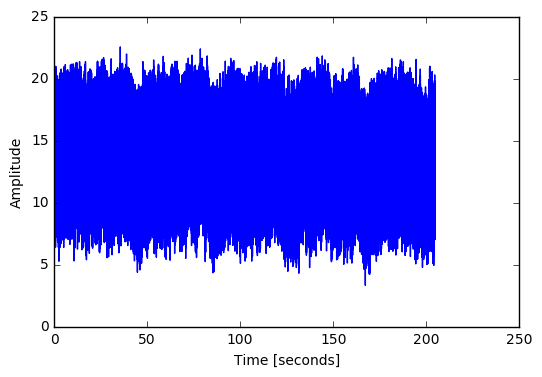

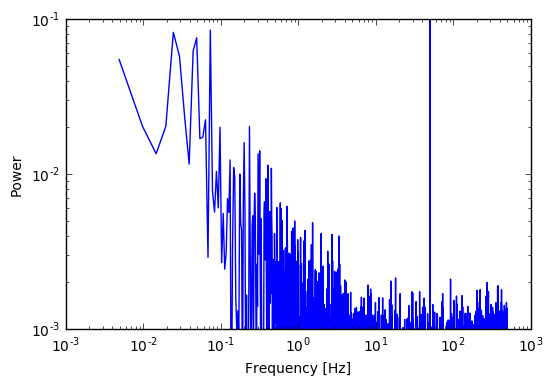

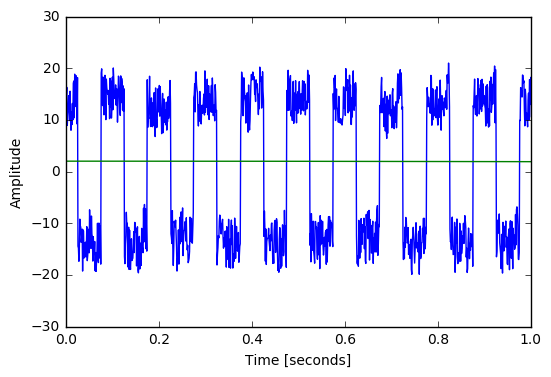

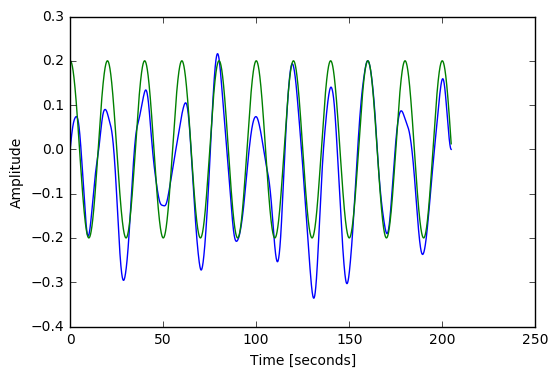

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

%matplotlib inline

# This function generates an array of length nrows 
# containing 1/f noise.

def voss(nrows, ncols=16):
    
    # From Allen Downey, Think DSP
    
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

# User adjustable parameters:

# Properties of the signal:

signalFreq       = 0.05
signalAmplitude  = 0.2

# Properties of the chopper and lock-in detection:

choppingFreq     = 10.0
lockinPhaseDelay = 0

# Digital sampling:

dt               = 0.001
numSamples       = 200 * 2**10

# Generate an array of sampling times.

t = np.linspace(0, dt * (numSamples - 1), numSamples)

# Convert the times to fourier space so that we can 
# plot the power spectrum.

f = np.fft.rfftfreq(t.size, dt)

# Generate the signal. It is just a cosine wave.

signal = signalAmplitude * np.cos(2 * np.pi * signalFreq * t)

# Generate noise consisting of the sum of 1/f noise, 
# 50 Hz mains "hum", and white noise.

noise = voss(numSamples) + \
        np.cos(2 * np.pi * 50.0 * t) + \
        10 * np.random.random(numSamples)
        
# Add the noise to the signal, and calculate 
# the power spectrum of the result.

signalPlusNoise = signal + noise
powerSpectrum = abs(np.fft.rfft(signalPlusNoise) * 2 / numSamples) ** 2

# Plot the signal + noise, and its power spectrum.

plt.plot(t, signalPlusNoise)
plt.xlabel("Time [seconds]")
plt.ylabel("Amplitude")
plt.show()

plt.plot(f, powerSpectrum)
plt.loglog()
plt.ylim(0.001,0.1)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.show()

# Create the chopper and lock-in waveforms. We
# are using square waves.

chop   = -1 + 2 *(np.cos(2 * np.pi * choppingFreq * t) > 0)
lockin = -1 + 2 *(np.cos(2 * np.pi * choppingFreq * t + \
                         lockinPhaseDelay) > 0)

# Apply the chopper, followed by the lock-in. Note
# that the signal is chopped, and the noise isn't.

choppedSignalPlusNoise = signal * chop + noise
lockinOutput = choppedSignalPlusNoise * lockin

# Plot the raw lock-in output, and the signal (amplified).

plt.plot(t, lockinOutput)
plt.plot(t, signal * 10)
plt.xlim(0, 1.0)
plt.xlabel("Time [seconds]")
plt.ylabel("Amplitude")
plt.show()

# Finally, apply a bandpass filter to the lock-in output,
# and plot the recovered signal.

b, a = scipy.signal.butter(2, [0.00001, 0.0002], 'bandpass')
smoothedLockinOutput = scipy.signal.filtfilt(b, a, lockinOutput, method='gust')

plt.plot(t, smoothedLockinOutput)
plt.plot(t, signal)
plt.xlabel("Time [seconds]")
plt.ylabel("Amplitude")
plt.show()
    


# Homodyne and heterodyne detection

The terms *homodyne* and *heterodyne* detection are commonly used.

*Homodyne* detection is the same as lock-in detection, it is where the signal of interest is modulated by a reference frequency, and detected at this same frequency.

In *heterodyne* detection, the signal (at a frequency $f_1$) is modulated by a reference frequency $f_2$, and the output comes from detecting the signal at the difference frequency $f_1-f_2$. Heterodyne detection is commonly used to bring a high frequency signal into the range where it can be easily analysed. E.g., in THz astronomy the signals are too high in frequency to be digitized directly, but by mixing the signals with a reference local oscillator signal at a nearby frequency, the signal can be brought down to the GHz regime where digitization is possible.

Heterodyne detection uses the same principle as listening to the beat frequency between two audio sources that are close in frequency.


# Spread spectrum transmission of radio signals

Spread spectrum radio transmission can be thought of as a extension of lock-in detection. Rather than modulating the signal with a fixed frequency sine-wave, spread spectrum works by using a sequence of frequencies selected by a psuedo-random number generator. This has a number of advantages, particularly for military and secure communications, e.g., 

- the signal is spread over a large bandwidth, making it more immune to interference (or deliberate jamming) at particular frequencies,

- unless you know the psuedo-random number generator and the seed, the signal will appear to be noise, and will be very difficult to intercept, or even detect.

The spread spectrum was invented by the Hollywood actress Hedy Lamarr. Her story is well worth reading about. There is also a 2017 film about her called *Bombshell*.